**Описание проекта**

В нашем распоряжении есть список гипотез для увеличения выручки. Цель - приоритизиовать гипотезы, запустить A/B-тест и проанализировать результаты. 

**Ход исследования**

- [1. Обзор данных](#Обзор_данных)
- [2. Работа с A/B тестом:](#Предобработка_данных)
  - [приоритизация гипотез;](#регистр)
  - [анализ А/Б теста;](#тип)
- [3. Общий вывод](#функции)


**Описание данных**

Файл /datasets/hypothesis.csv.
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 
Файл /datasets/orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

<a name="Обзор_данных"></a>
## 1. Обзор и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import seaborn as sns
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
import warnings
warnings.simplefilter('ignore')

In [2]:
try:
    visitors, orders, hypothesis = (
                            pd.read_csv('visitors.csv'),
                            pd.read_csv('orders.csv'),
                            pd.read_csv('hypothesis.csv')
                            )
except:
    visitors, orders, hypothesis = (
                            pd.read_csv('/datasets/visitors.csv'),
                            pd.read_csv('/datasets/orders.csv'),
                            pd.read_csv('/datasets/hypothesis.csv')
                            )

In [3]:
for i in [visitors, orders, hypothesis]:
    display(i.head())
    display(i.info())
    print('Дубликатов:' , i.duplicated().sum())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Дубликатов: 0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Дубликатов: 0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Дубликатов: 0


Приведем столбцы с датами к нужному формату

In [4]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

***Вывод:***
- привели столбцы с указанием даты в формат 'datetime';
- Пропусков и дубликатов, в имеющихся данных, нет.

Теперь можем приступить к работе с данными

<a name="Предобработка_данных"></a>
## 2. Работа с A/B тестом

<a name="приоритетные_гипотезы"></a>

**Применим фреймворк ICE**

In [5]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 1)
display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending = False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


Наиболеее перспективные гипотезы: 9, 1, 8

***Применим фреймворк RICE***

In [6]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

hypothesis[['Hypothesis', 'RICE']].sort_values(by= 'RICE', ascending = False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Наиболеее перспективные гипотезы: 8, 3, 1

Наиболее приориоритетными гипотезами являются:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

По ICE, также перспективной гипотезой выглядит 'Запустить акцию, дающую скидку на товар в день рождения', но по RICE она не выглядит перспективной из-за малого кол-ва клиентов, которых она затронет.

По RICE, также перспективной выглядит гипотеза 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа', по по ICE показывает не большой бал из-за малого влияние на пользователя.

<a name="проверим"></a>
**Проверим, есть ли клиенты входящие в обе группы**

In [7]:
in_both_groups = orders.groupby('visitorId').agg({'visitorId' : 'max',  'group': 'nunique'}).query('group == 2')

in_both_groups = in_both_groups['visitorId'].tolist ()

Число пользователей, входящих в обе группы: 58. 

Мы не можем учитывать данных пользователей при оценке A/B теста, т.к. не можем точно определить, что именно побудило их совершить покупку, следовательно, результат может быть смазан. Поэтому удалим их.

In [8]:
orders = orders.query('visitorId != @in_both_groups')

<a name="Постром"></a>
***Построим график кумулятивной выручки по группам.***

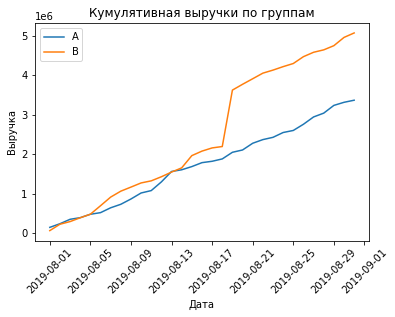

In [9]:
# Создадим датафрейм с уникальными парами значений 'date' и 'group', таблицы orders
datesGroups = orders[['date' , 'group']].drop_duplicates()

# получаем агрегированные, кумулятивные по дням, данные о заказах 
ordersAggregated = (datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
    {'date': 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum' }), axis=1)
                    .sort_values(by = ['date' , 'group']))
# получаем агрегированные, кумулятивные по дням, данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
    {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by = ['date' , 'group'])

# обьеденим полученные данные
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Выведим данные из каждой группы в отдельные таблицы
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B']



plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label ='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label ='B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Кумулятивная выручки по группам')
plt.legend();

группа В лидирует на протяжении всего эксперемента. Ближе к середине теста, есть резкий скачок выручки в группе В, вероятно это сигнализирует о наличие аномалий в эксперементе.

***Построим график кумулятивного среднего чека по группам***

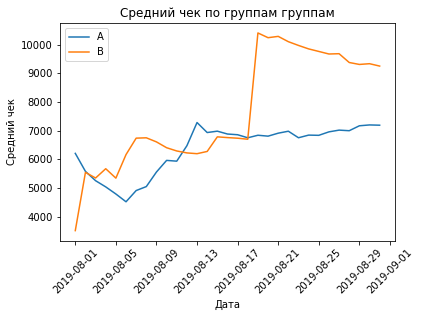

In [10]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label ='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label ='B')

plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Средний чек по группам группам')
plt.legend();

аналогичная ситуация, в обоих сегметах есть всплески

***Построим график относительного изменения кумулятивного среднего чека группы B к группе A.***

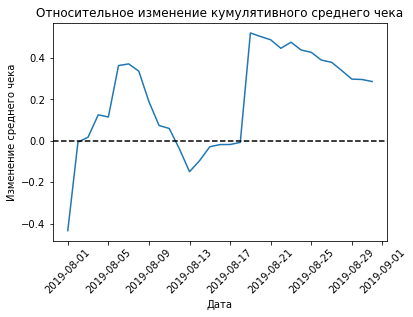

In [11]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.ylabel('Изменение среднего чека')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Относительное изменение кумулятивного среднего чека');

***Вывод:***
В нескольких точках график резко «скачет», что, в очередной раз, сигнализирует нам о крупных вбросах.

***Построим график кумулятивного среднего количества заказов на посетителя по группам.***

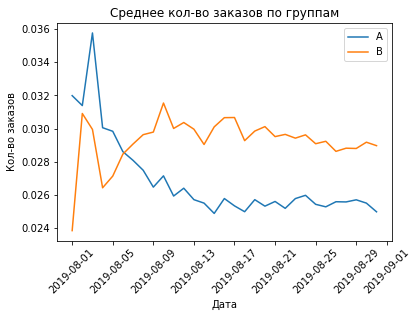

In [12]:
cumulativeRevenueA['conversion'] = cumulativeRevenueA['orders']/cumulativeRevenueA['visitors']
cumulativeRevenueB['conversion'] = cumulativeRevenueB['orders']/cumulativeRevenueB['visitors']

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['conversion'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['conversion'], label='B')

plt.legend()
plt.ylabel('Кол-во заказов')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Среднее кол-во заказов по группам')
plt.show()


***Вывод:***
Начиная с 6 августа, кол-во заказов в группе B стабильно выше

***Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A***

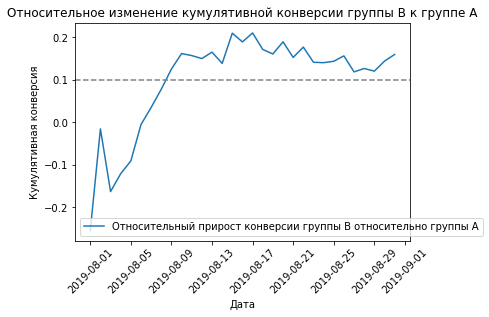

In [13]:
mergedCumulativeConversions = (cumulativeRevenueA[['date','conversion']].merge(
    cumulativeRevenueB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0.1, color='grey', linestyle='--')

plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.show()

***Вывод:*** Начиная с 6 августа, конверсия группы B стабильно выше

***Построим точечный график количества заказов по пользователям.***

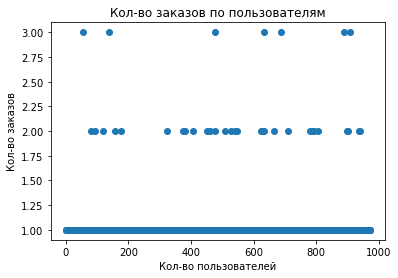

In [14]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'}))

ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.ylabel('Кол-во заказов')
plt.xlabel('Кол-во пользователей')
plt.title('Кол-во заказов по пользователям')
plt.show()


Много пользователей с 2 заказами, также есть пользователи с 3 заказами, пока не ясно, считать их аномалиями или нет.

***Посчитаем 95-й и 99-й перцентили количества заказов на пользователя***

In [15]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

Не более 1% пользователей оформили 2.

Лучшим решением будет взять 1 заказ в качестве верхней границы на одного пользователя.

***Построим точечный график стоимостей заказов***

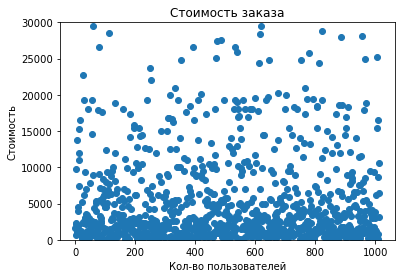

In [16]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.ylim([0, 30000])
plt.ylabel('Стоимость')
plt.xlabel('Кол-во пользователей')
plt.title('Стоимость заказа')
plt.show();

***Построим допольнительный график, без вброса***

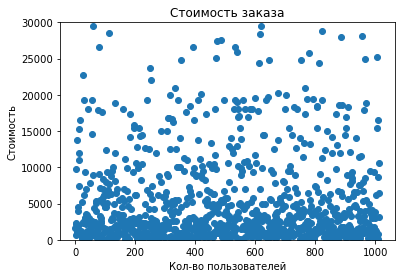

In [17]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.ylim([0, 30000])
plt.ylabel('Стоимость')
plt.xlabel('Кол-во пользователей')
plt.title('Стоимость заказа')
plt.show();

Большинство заказов находятся в пределах 20 000 руб., есть аномально большой заказ 1 200 000 руб. + .

***Посчитаем 95-й и 99-й перцентили стоимости заказов***

In [18]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

***Вывод:***
Не более 5% процентов заказов привышают стоимость в 26 785 и не более 1% в 53 904. Установим границу заказа в 26 785 руб.

***Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным***

Проверка гипотезы.

Нулевая гипотеза : различий в кол-ве заказов между группами нет.

Альтернативная гипотеза: различия в кол-ве заказов между группа миесть.

Alpha = 0.05

Проверим гипотезу методом ***Манна-Уитни*** (st.mannwhitneyu)

In [19]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'}),axis=1)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    'date', as_index=False).agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']


ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1,).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    'date', as_index=False).agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})

ordersADaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']


ordersBCummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1,).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


data = (ordersADaily
    .merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

In [20]:
ordersByUsersA = (orders[orders['group'] == 'A']
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId': pd.Series.nunique}))

ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B']
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId': pd.Series.nunique}))

ordersByUsersB.columns = ['userId', 'orders'] 


sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


***Вывод:***
По сырым данным различия между группами есть, p-value = 0.011. Нулевую гипотезу, что различий в среднем кол-ве заказов между группами нет - отвергаем. Относительный выйгрыш группы B равен 16% 

***Посчитам статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным***

***Проверка гипотезы.***

Нулевая гипотеза : различий в среднем чеке между группами нет.

Альтернативная гипотеза: различия в среднем чеке между группами есть.

Alpha = 0.05

Проверим гипотезу методом ***Манна-Уитни*** (st.mannwhitneyu)

In [21]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.829
0.287


p-value = 0.829, следовательно, у нас нет причин отвергать нулевую гипотезу. 

Также можем отметить, что среднй чек в группе 'B'  выше на 28.7%.

***Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.***

Проверка гипотезы.

Нулевая гипотеза : различий в кол-ве заказов между группами нет.

Альтернативная гипотеза: различия в кол-ве заказов между группа миесть.

Alpha = 0.05

Проверим гипотезу методом ***Манна-Уитни*** (st.mannwhitneyu)

In [22]:
# Найдем 'аномальных' пользователей
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],],axis=0,)

usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']

abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

# исключим 'аномальных' пользователей из наших выборок
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders',),],axis=0,)

In [23]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders',),],axis=0,)

# Применим статистический критерий Манна-Уитни к полученным выборкам
print('{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.012
0.182


***Вывод:*** 

Мы получили p-value = 0.012, против p-value = 0.011 по «сырым» данным. Мы вновь отвергаем нулевую гипотезу. 

Также стоить отметить, что выйгрыш группы 'B' уже составляет 18.2%, против 16% по «сырым» данным.

***Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.***

***Проверка гипотезы.***

Нулевая гипотеза : различий в среднем чеке между группами нет.

Альтернативная гипотеза: различия в среднем чеке между группами есть.

Alpha = 0.05

Проверим гипотезу методом ***Манна-Уитни*** (st.mannwhitneyu)

In [24]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]
                  ['revenue'],)[1]))
print("{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]
                  ['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId']
                  .isin(abnormalUsers)),)]['revenue'].mean()- 1))

0.646
-0.048


***Вывод:***p-value = 0.646, следовательно, у нас нет причин отвергать нулевую гипотезу. 

Можно отметить, что после фильтрации данных, относительный выйгрыш B снизился с 28.7% до -4.8%  по сравнению с группой B. Что в явной форме нам указывает на критичное влияние вбросов на результат.

***Принятие решения  по результатам теста.***

По итогу, на основании проведенного исследования, мы можем сделать вывод, что при сравнительно равной сумме чека в испытуемых группах, клиенты из группы 'В' значительно чаще совершают заказы по сравнению с гуппой 'А' ( на 16% по «сырым» данным и 18.2% по «очищенным»), что в перспективе может значительно повысить выручку магазина.

Основываясь на вышеописанных фактах, мы принимаем решение о остановке тестирования и констатируем победу группы B.